In [23]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from utils import get_financial_data

# Load financial data

In [24]:
df = get_financial_data()
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Daily Return,Lagged Return,Log Return,SMA 14,ATR 14
Date,,,,,,,,,,
2015-01-02,24.288586,24.757340,23.848711,24.746232,212818400,-0.018494,-0.019019,-0.009558,24.694020,0.555871
2015-01-05,23.604332,24.137513,23.417720,24.057535,257142000,-0.018838,-0.009512,-0.028576,24.638798,0.581737
2015-01-06,23.606550,23.866475,23.244431,23.668754,263188400,-0.002628,-0.028172,0.000094,24.607536,0.542859
2015-01-07,23.937574,24.037545,23.704307,23.815387,160423600,0.005131,0.000094,0.013925,24.623405,0.511758
2015-01-08,24.857315,24.915077,24.148629,24.266374,237458000,0.024352,0.014023,0.037703,24.662759,0.532546


# Converting Pandas Dataframe to Numpy ndarray

In [25]:
X = df.to_numpy()
X.shape

(2608, 10)

# Split and scale

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'scalers/standard_scaler.save')

print(f'Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}')

Train: (2086, 10), Test: (522, 10)


# Create sequences

- many-to-one

In [5]:
from utils import create_sequence

X_train_seq, y_train_seq = create_sequence(X_train_scaled, input_seq_len=10)
X_test_seq, y_test_seq = create_sequence(X_test_scaled, input_seq_len=7)

print(f'X_train, y_train: {X_train_seq.shape} {y_train_seq.shape}')
print(f'X_test, y_test: {X_test_seq.shape} {y_test_seq.shape}')

X_train, y_train: (2075, 10, 10) (2075, 10)
X_test, y_test: (514, 7, 10) (514, 10)


# Data preparation

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Convert ndarray to torch Tensor
X_train_seq, X_test_seq, y_train_seq, y_test_seq = torch.Tensor(X_train_seq), torch.Tensor(X_test_seq), torch.Tensor(y_train_seq), torch.Tensor(y_test_seq)
# Put tensors to available device
X_train_seq, X_test_seq, y_train_seq, y_test_seq = X_train_seq.to(device), X_test_seq.to(device), y_train_seq.to(device), y_test_seq.to(device)

In [8]:
from torch_utils import StockDataset

batch_size = 128

dataset_train = StockDataset(X_train_seq, y_train_seq)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

dataset_test = StockDataset(X_test_seq, y_test_seq)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Model definition

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=6, dropout=0.1, predict_sequence = False):
        super(LSTMModel, self).__init__()

        self.predict_sequence = predict_sequence
        
        self.lstm = nn.LSTM(input_size=input_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            dropout=dropout,
                            batch_first=True)
        
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        
        output, (h_out, c_out) = self.lstm(x)
        #torch.allclose(output[:, -1, :], h_out[-1]

        if self.predict_sequence:
            out = self.fc_out(output)
        else:
            out = self.fc_out(output[:, -1, :])
        
        return out

In [10]:
n_features = 10
hidden_dim = 128
num_layers = 3
dropout = 0.3
predict_sequence = False

model = LSTMModel(input_dim=n_features, 
                  output_dim=n_features, 
                  hidden_dim=hidden_dim, 
                  num_layers=num_layers, 
                  dropout=dropout, 
                  predict_sequence=predict_sequence)

model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model training

In [11]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

#writer = SummaryWriter('logs')
#train_per_epoch = int(len(dataset_train) / batch_size)

epochs = 200

model.train()

for epoch in range(epochs+1):

    #loop = tqdm(enumerate(dataloader_train), total=len(dataloader_train), leave=True)
    epoch_loss = 0

    for (data, target) in dataloader_train:
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        #writer.add_scalar('loss', loss.item(), (epoch * train_per_epoch) + idx)
        #loop.set_description(f"Epoch {epoch}/{epochs}")
        #loop.set_postfix(loss=loss.item())
    
    if (epoch) % 50 == 0:
        #loop.write(f"Epoch {epoch}/{epochs} Avg Loss: {epoch_loss / len(dataloader_train):.4f}")
        print(f"Epoch {epoch}/{epochs} Avg Loss: {epoch_loss / len(dataloader_train):.4f}")

timestamp = datetime.now().strftime("%d-%m-%Y")
torch.save(model.state_dict(), f"models/lstm_m2o_{timestamp}.pth")

Epoch 0/200 Avg Loss: 1.0003
Epoch 50/200 Avg Loss: 0.3134
Epoch 100/200 Avg Loss: 0.2404
Epoch 150/200 Avg Loss: 0.2059
Epoch 200/200 Avg Loss: 0.1252


# Model evaluation

In [12]:
model.eval()

with torch.no_grad():

    val_output = model(X_test_seq)
    val_loss = criterion(val_output, y_test_seq)
    print(f'Validation loss: {val_loss.item()}')

Validation loss: 0.725715160369873


# Plot train results

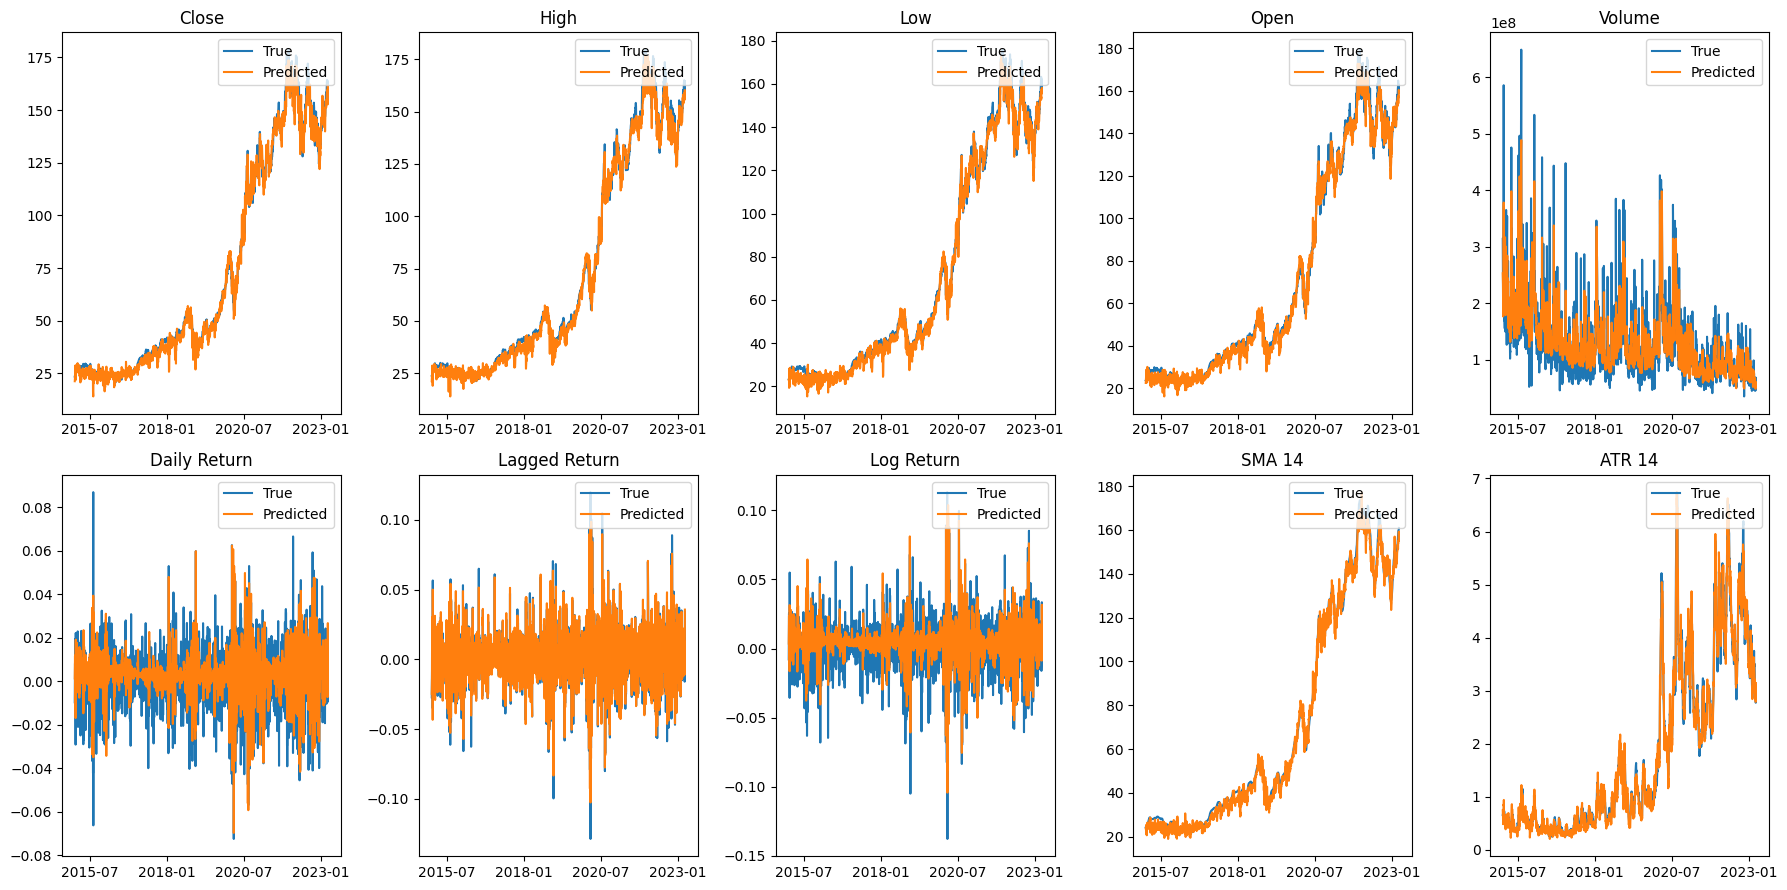

In [13]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

y_true = scaler.inverse_transform(y_train_seq.cpu().detach().numpy())
y_pred = model(X_train_seq).cpu().detach().numpy()
y_pred = scaler.inverse_transform(y_pred)

train_dates = df.index[:len(X_train_seq)]

for idx, c in enumerate(df.columns):
    axes[idx].plot(train_dates, y_true[:, idx], color='#1f77b4', label='True')
    axes[idx].plot(train_dates, y_pred[:, idx], color='#ff7f0e', label='Predicted')
    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[idx].xaxis.set_major_locator(mdates.MonthLocator(interval=30))

plt.tight_layout()
plt.show()

# Plot test results

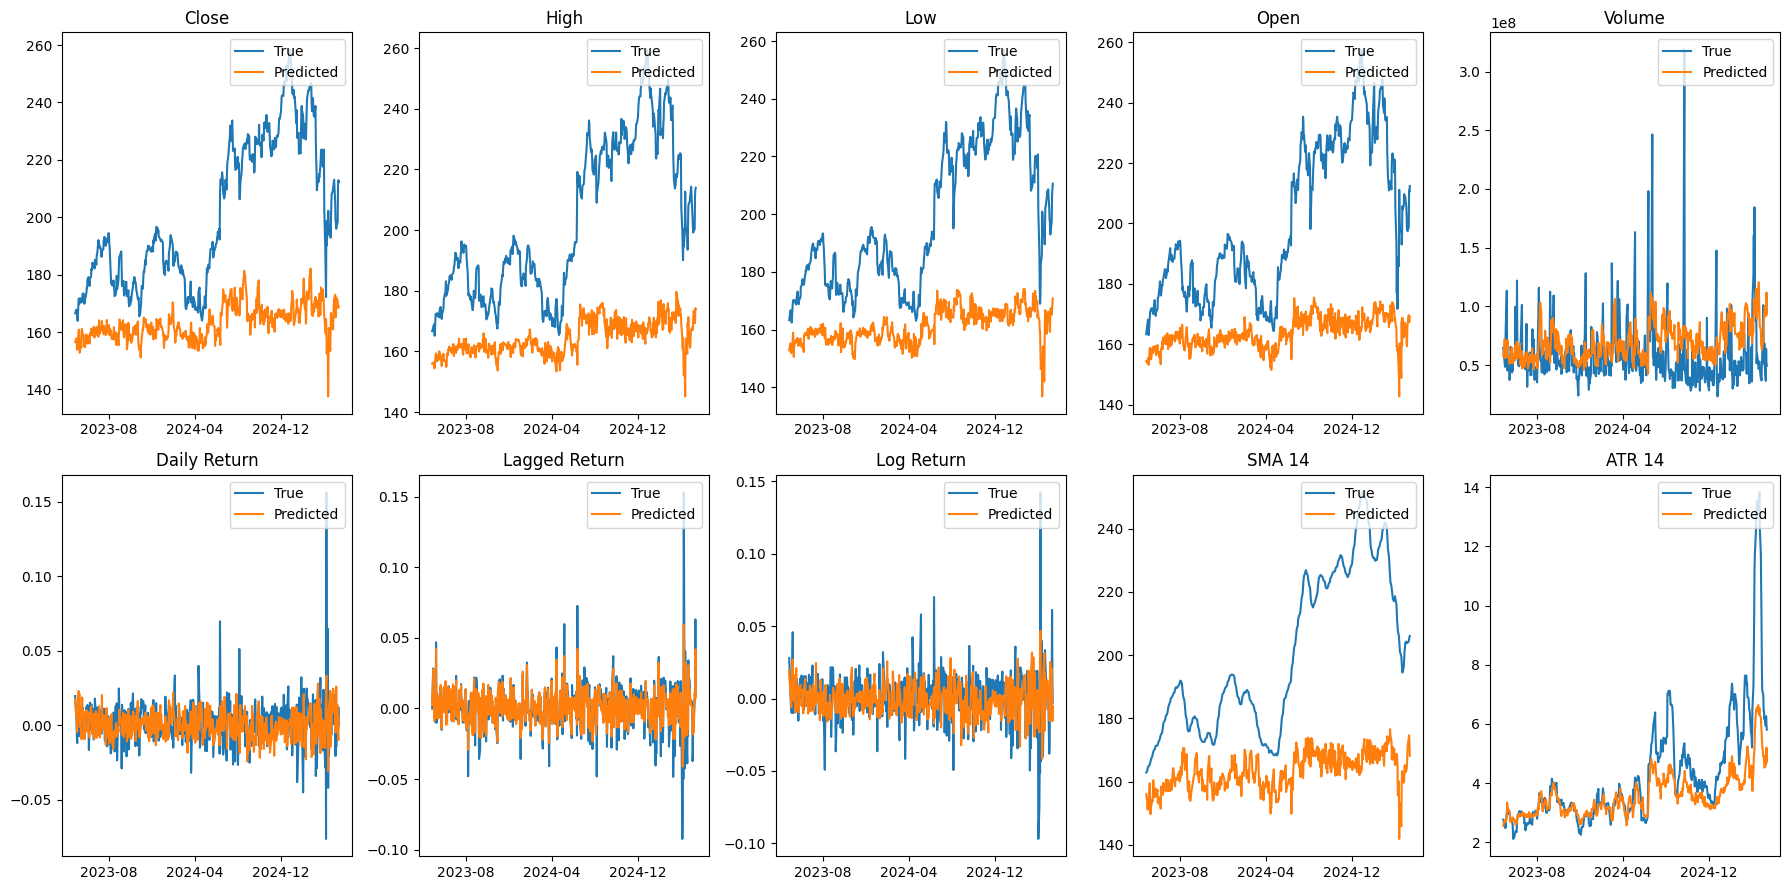

In [14]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

y_true = scaler.inverse_transform(y_test_seq.cpu().detach().numpy())
y_pred = model(X_test_seq).cpu().detach().numpy()
y_pred = scaler.inverse_transform(y_pred)

test_dates = df.index[-len(X_test_seq):]

for idx, c in enumerate(df.columns):
    axes[idx].plot(test_dates, y_true[:, idx], color='#1f77b4', label='True')
    axes[idx].plot(test_dates, y_pred[:, idx], color='#ff7f0e', label='Predicted')
    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[idx].xaxis.set_major_locator(mdates.MonthLocator(interval=8))

plt.tight_layout()
plt.show()

# Create sequences

- many-to-many

In [15]:
X_train_seq, y_train_seq = create_sequence(X_train_scaled, input_seq_len=10, target_seq_len=10)
X_test_seq, y_test_seq = create_sequence(X_test_scaled, input_seq_len=7, target_seq_len=7)

print(f'X_train, y_train: {X_train_seq.shape} {y_train_seq.shape}')
print(f'X_test, y_test: {X_test_seq.shape} {y_test_seq.shape}')

X_train, y_train: (2066, 10, 10) (2066, 10, 10)
X_test, y_test: (508, 7, 10) (508, 7, 10)


In [16]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq = torch.Tensor(X_train_seq), torch.Tensor(X_test_seq), torch.Tensor(y_train_seq), torch.Tensor(y_test_seq)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = X_train_seq.to(device), X_test_seq.to(device), y_train_seq.to(device), y_test_seq.to(device)

In [17]:
batch_size = 128

dataset_train = StockDataset(X_train_seq, y_train_seq)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

dataset_test = StockDataset(X_test_seq, y_test_seq)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [18]:
n_features = 10
hidden_dim = 128
num_layers = 3
dropout = 0.1
predict_sequence = True

model = LSTMModel(input_dim=n_features, 
                  output_dim=n_features, 
                  hidden_dim=hidden_dim, 
                  num_layers=num_layers, 
                  dropout=dropout, 
                  predict_sequence=predict_sequence)

model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [19]:
#writer = SummaryWriter('logs')
epochs = 500
train_per_epoch = int(len(dataset_train) / batch_size)

model.train()

for epoch in range(epochs+1):

    #loop = tqdm(enumerate(dataloader_train), total=len(dataloader_train), leave=True)
    epoch_loss = 0

    for (data, target) in dataloader_train:
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        #writer.add_scalar('loss', loss.item(), (epoch * train_per_epoch) + idx)
        #loop.set_description(f"Epoch {epoch}/{epochs}")
        #loop.set_postfix(loss=loss.item())
    
    if (epoch) % 50 == 0:
        print(f"Epoch {epoch}/{epochs} Avg Loss: {epoch_loss / len(dataloader_train):.4f}")
        #loop.write(f"Epoch {epoch}/{epochs} Avg Loss: {epoch_loss / len(dataloader_train):.4f}")

timestamp = datetime.now().strftime("%d-%m-%Y")
torch.save(model.state_dict(), f"models/lstm_m2m_{timestamp}.pth")

Epoch 0/500 Avg Loss: 0.9477
Epoch 50/500 Avg Loss: 0.4011
Epoch 100/500 Avg Loss: 0.3521
Epoch 150/500 Avg Loss: 0.2797
Epoch 200/500 Avg Loss: 0.2021
Epoch 250/500 Avg Loss: 0.1338
Epoch 300/500 Avg Loss: 0.0832
Epoch 350/500 Avg Loss: 0.0685
Epoch 400/500 Avg Loss: 0.0890
Epoch 450/500 Avg Loss: 0.0412
Epoch 500/500 Avg Loss: 0.0368


In [20]:
model.eval()

with torch.no_grad():

    val_output = model(X_test_seq)
    val_loss = criterion(val_output, y_test_seq)
    print(f'Validation loss: {val_loss.item()}')

Validation loss: 1.002680778503418


# Plot train results (one random sequence)

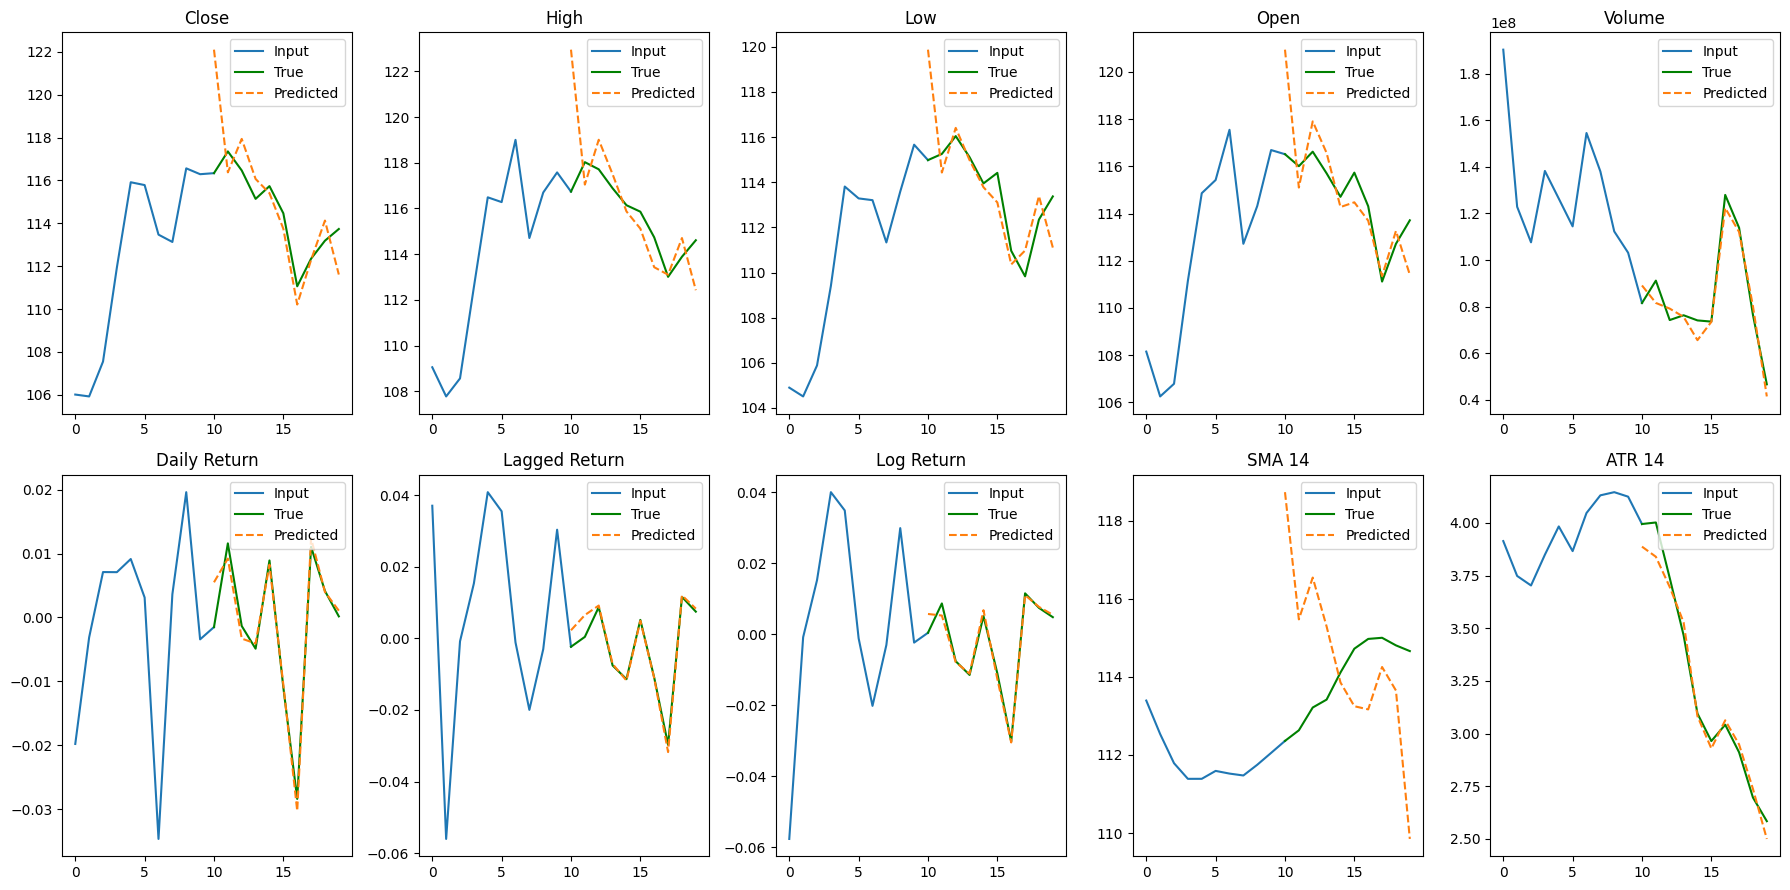

In [21]:
rand_idx = np.random.randint(0, len(X_train_seq))

x = X_train_seq[rand_idx].cpu().detach().numpy()
y_true = y_train_seq[rand_idx].cpu().detach().numpy()
y_pred = model(X_train_seq[rand_idx]).cpu().detach().numpy()

x = scaler.inverse_transform(x)
y_true = scaler.inverse_transform(y_true)
y_pred = scaler.inverse_transform(y_pred)

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

for idx, c in enumerate(df.columns):

    input_seq = x[:, idx]
    true_seq = y_true[:, idx]
    pred_seq = y_pred[:, idx]

    axes[idx].plot(range(len(input_seq)+1), np.hstack((input_seq, true_seq[0])), label='Input', color='#1f77b4')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(true_seq)), true_seq, label='True', color='green')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(pred_seq)), pred_seq, label='Predicted', color='#ff7f0e', linestyle='dashed')

    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')

plt.tight_layout()
plt.show()

# Plot test results (one random sequence)

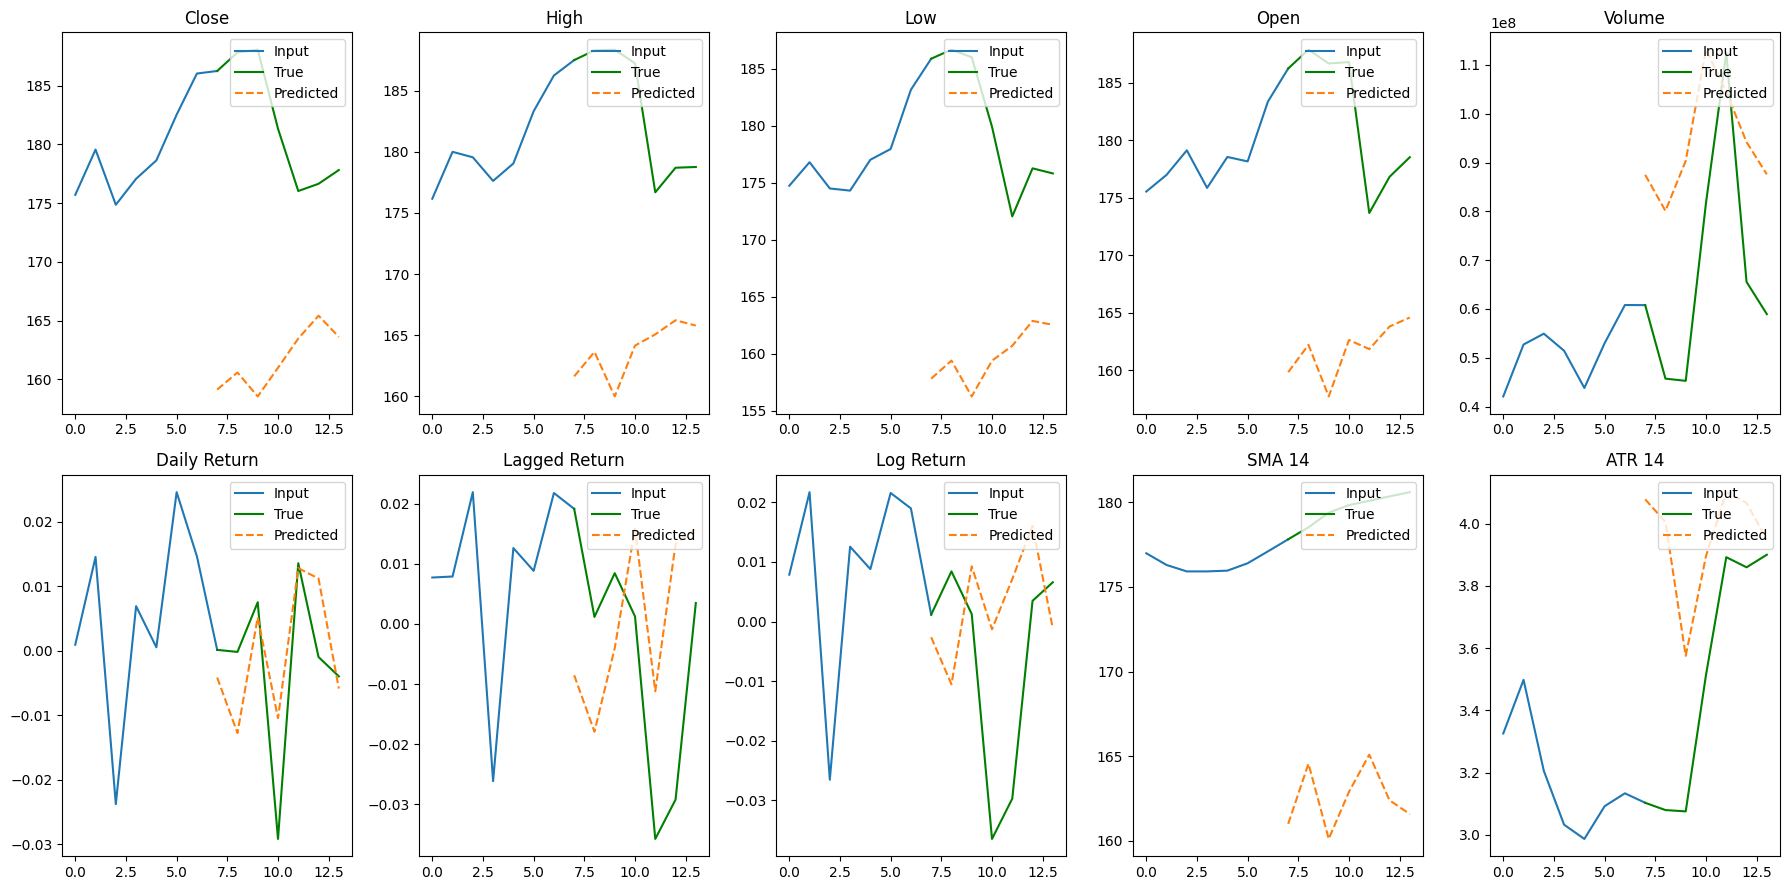

In [22]:
rand_idx = np.random.randint(0, len(X_test_seq))

x = X_test_seq[rand_idx].cpu().detach().numpy()
y_true = y_test_seq[rand_idx].cpu().detach().numpy()
y_pred = model(X_test_seq[rand_idx]).cpu().detach().numpy()

x = scaler.inverse_transform(x)
y_true = scaler.inverse_transform(y_true)
y_pred = scaler.inverse_transform(y_pred)

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

for idx, c in enumerate(df.columns):

    input_seq = x[:, idx]
    true_seq = y_true[:, idx]
    pred_seq = y_pred[:, idx]

    axes[idx].plot(range(len(input_seq)+1), np.hstack((input_seq, true_seq[0])), label='Input', color='#1f77b4')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(true_seq)), true_seq, label='True', color='green')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(pred_seq)), pred_seq, label='Predicted', color='#ff7f0e', linestyle='dashed')

    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')

plt.tight_layout()
plt.show()